# Group 6 Final Project

**Group Members**
- Beatriz Leal (43100)
- Inês Outor (53553)
- João Gonçalves (51268)
- Mariana Alves (54371)
- Patrícia Fonseca (53004)

## Business Problem

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data - including telco and transactional information - to predict their clients' repayment abilities.

In the applications table, we have the demographic data of the clients at the time of the application, and more specific details about the credit requested. 
We also have access to the previous applications for "Home Credit" loans of the borrowers (previous_applications) and the repayment history of those (installment_payments). Additionally, we have information on previous credits provided by other financial institutions that were reported to Credit Bureau to "Home Credit" applicants. 
Finnaly, in credit_card_balance, we have monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

We intend to use both the current data and previous loans data of a client to predict his behavior in the future, will he have problems paying the loans (late payments, no payments)? This will help Home Credit making the decision of wether they should reject the loan request, or not.


Our objective is to predict the Target variable:
- 1 - The loan is gonna be rejected because the client has payment difficulties
- 0 - The loan is gonna be accepted

## Methodology

Each table we had available was analysed individually, and for each one of them, we meticulously handled missing values and outliers, among other concerns. After that, we preprocessed each one of those tables by imputing missing values and transforming categorical features through the one-hot encoder. With the exception of the Application table, which we consider the main table for our analysis and is positioned in the center of the others, in the remaining tables we faced the challenge of having more than one entry per current application (identified by an id, SK_ID_CURR), as they are related to historical data of a client currently making an application. To overcome this obstacle, the data from these tables was grouped using summary statistics carefully chosen by us, so that meaningful information could be gathered.

Later on, we proceeded to merging all tables into a single one and dropping the columns with a correlation with the target lower than 0.01, assuming they would not be relevant when predicting if a client’s current loan request would be refused or not. Since not all candidates have information on previous applications in Home Credit and other institutions, this merge will result in a high number of missing values. We considered that it would be incorrect to input missing values since these clients may not have data for some specific reason, and for that reason, we created new columns that described if the value for a specific column was null or not for the client being considered. Finally, with all tables merged, we ran the standard smaller through our data.

After all these previous steps, we were able to proceed to the modelling phase. When developing models, we decided to focus on two specific ones that would be a better fit for our business problem: a random forest classifier and a logistic regression. For each one of these, we fine-tuned the necessary parameters, and addressed the fact that our data is imbalanced by also fine-tuning the class_weights. In this final phase, we aimed at finding a model that would return a higher recall score, which we determined that would be the best metric, since in this case a higher cost is associated to false negative - accepting a client’s loan request when, in fact, the client has difficulties paying for it and therefore his request should not be accepted. Considering that this scenario would be costly for the company, we focused on developing a model with the highest recall possible.

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from joblib import parallel_backend
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

### Applications Table

Static data for all applications. One row represents one loan in our data sample.

In [2]:
#Path for the file, change it if necessary
applications = pd.read_csv("application_train.csv")

#Values "XNA" (not availables) will be replaced by NaN values
applications.replace("XNA", np.nan, inplace=True)

In [3]:
#See if there are any duplicated rows
duplicate_rows = applications[applications.duplicated()]
print(f"There are {len(duplicate_rows)} duplicate rows in the applications table")

There are 0 duplicate rows in the applications table


#### Analyzing missing values

Building a model on variables that have higher than 40% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values, therefore, we will exclude the variables with missing values higher or equal to 40%


In [4]:
missing_percentages = applications.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
applications.drop(columns=columns_to_drop,inplace=True)

In [5]:
applications.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_C

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [6]:
variables_type = pd.DataFrame(applications.dtypes)

#Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

#Get all integer variables 
int_variables = list(variables_type[variables_type[0] == "int64"].index)

#Get all float variables
float_variables = list(variables_type[variables_type[0] == "float64"].index)

#Get all binary variables
cat_binary_variables = []
for i in applications:
    if ((list(applications[i].unique()) == [0,1]) or (list(applications[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "TARGET"]]

#Merge all numerical variables
num_variables = int_with_no_binary + float_variables

#Print the different variable types
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
Categorical variables (binary): ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
Numerical variab

#### Cleaning all remaining variables

##### Categorical variables

In [7]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, applications[i].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' nan]
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 

Findings:
- FLAG_OWN_CAR and FLAG_OWN_REALTY are already binary variables codified in a different way (Yes/No)

In [8]:
#Change binary variables from Yes/No to 1/0
applications["FLAG_OWN_CAR"] = applications["FLAG_OWN_CAR"].apply(lambda x: 0 if x == 'N' else 1)
applications["FLAG_OWN_REALTY"] = applications["FLAG_OWN_REALTY"].apply(lambda x: 0 if x == 'N' else 1)

#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_OWN_CAR","FLAG_OWN_REALTY"]]
cat_binary_variables.extend(["FLAG_OWN_CAR","FLAG_OWN_REALTY"])

##### Numerical variables

In [9]:
#Using describe method for numerical variables to get summary statistics and explore the data
applications[num_variables].describe()

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,2.052463,2.031521,12.063419,1.687979e+05,5.990260e+05,27108.573909,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,4363.988632,141275.766519,1509.450419,0.509034,0.502737,3.265832,2.371231e+05,4.024908e+05,14493.737315,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,258025.500000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Findings:
- "DAYS(...)" variables are counter-intuitively negative
- "REGION_RATING_CLIENT(...)" variables should be consider categorical since they only have values 1, 2 and 3
- DAYS_EMPLOYED mean is 63815 (equivalent to around 174.8 years of experience), so there should be outliers (wrongly inserted values) we need to look deeper at

In [10]:
#Exclude the "REGION_RATING_CLIENT(...)" variables from num_variables and include them in cat_variables (useful for the final pipeline)
num_variables = [i for i in num_variables if i not in ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]
cat_variables.extend(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

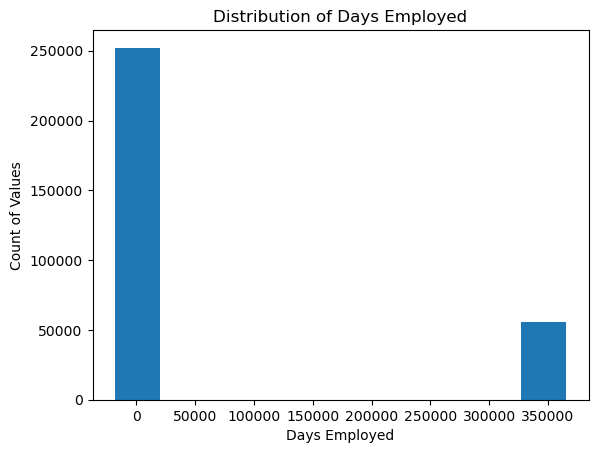

In [14]:
#Plot the DAYS_EMPLOYED variable to see why mean is equivalent to 174.8 years of experience (outliers that don't make sense)
plt.hist(applications["DAYS_EMPLOYED"])
plt.title("Distribution of Days Employed")
plt.xlabel("Days Employed")
plt.ylabel("Count of Values")
plt.show()

In [12]:
# Replace all outliers (impossible values) by NaN
applications.loc[applications["DAYS_EMPLOYED"] > 325000, "DAYS_EMPLOYED"] = np.nan

In [13]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in applications.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Transformation Pipeline

In [14]:
# Create a DataframeSelector Class to be used on the pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, applications):
        return applications[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names
    
# Create a NegativeToPositive Class to transform day columns
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, applications):
        applications[self.attribute_names] = abs(applications[self.attribute_names])
        return applications[self.attribute_names]

In [15]:
#Create Pipelines for each type: Numerical, Days, Categorical, Binary
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

#Create preprocessor pipeline
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

#Fit pipeline and transform it
preprocess_pipeline.fit(applications)
preprocessed_applications = preprocess_pipeline.transform(applications)

#Get categorical values names after the pipeline preprocessor
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get all the features names
feature_names = num_variables + day_variables + cat_feature_names + cat_binary_variables

# Create a new dataframe with the new features after the preprocessor
transformed_applications_df = pd.DataFrame(preprocessed_applications, columns=feature_names)
transformed_applications_df = pd.concat([applications[["SK_ID_CURR", "TARGET"]], transformed_applications_df], axis=1)

# Add a sufix "_APP" to identify features from applications table 
transformed_applications_df.columns = ["SK_ID_CURR","TARGET"] + [col + '_APP' for col in transformed_applications_df.columns if col not in ["SK_ID_CURR","TARGET"]]

### Previous Applications Table


There is one row for each previous application related to loans in our data sample.

In [16]:
#Path for the file, change it if necessary
prev_app = pd.read_csv("previous_application.csv")

#Values "XNA" (not availables) will be replaced by NaN values
prev_app.replace("XNA", np.nan, inplace=True)

In [17]:
#See if there are any duplicated rows
duplicate_rows = prev_app[prev_app.duplicated()]
print(f"There are {len(duplicate_rows)} in the previous applications table")

There are 0 in the previous applications table


#### Analyzing missing values

Building a model on variables that have higher than 40% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values, therefore, we will exclude the variables with missing values higher or equal to 40%

In [18]:
missing_percentages = prev_app.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
prev_app.drop(columns=columns_to_drop,inplace=True)

# This is a categorical variable that has more than 2000 different values which doesn't makes sense to keep for analysis 
prev_app.drop(columns='SELLERPLACE_AREA',inplace=True)

#### Dividing the variables by type to facilitate the EDA and Data Cleaning


In [19]:
variables_type = pd.DataFrame(prev_app.dtypes)

# Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

# Get all integer variables 
int_variables = list(variables_type[variables_type[0] == "int64"].index)

# Get all float variables
float_variables = list(variables_type[variables_type[0] == "float64"].index)

# Get all binary variables
cat_binary_variables = []
for i in prev_app:
    if ((list(prev_app[i].unique()) == [0,1]) or (list(prev_app[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","SK_ID_PREV"]]

#Merge all numerical variables
num_variables = int_with_no_binary + float_variables

#Print the different variable types
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
Categorical variables (binary): ['NFLAG_LAST_APPL_IN_DAY']
Numerical variables: ['HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT']


#### Cleaning all remaining variables

##### Categorical variables

In [20]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, prev_app[i].unique())

NAME_CONTRACT_TYPE ['Consumer loans' 'Cash loans' 'Revolving loans' nan]
WEEKDAY_APPR_PROCESS_START ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
FLAG_LAST_APPL_PER_CONTRACT ['Y' 'N']
NAME_CONTRACT_STATUS ['Approved' 'Refused' 'Canceled' 'Unused offer']
NAME_PAYMENT_TYPE ['Cash through the bank' nan 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' nan 'VERIF' 'SYSTEM']
NAME_CLIENT_TYPE ['Repeater' 'New' 'Refreshed' nan]
NAME_PORTFOLIO ['POS' 'Cash' nan 'Cards' 'Cars']
CHANNEL_TYPE ['Country-wide' 'Contact center' 'Credit and cash offices' 'Stone'
 'Regional / Local' 'AP+ (Cash loan)' 'Channel of corporate sales'
 'Car dealer']
NAME_YIELD_GROUP ['middle' 'low_action' 'high' 'low_normal' nan]
PRODUCT_COMBINATION ['POS mobile with interest' 'Cash X-Sell: low' 'Cash X-Sell: high'
 'Cash X-Sell: middle' 'Cash Street: high' 'Cash'
 'POS household without interest' 'POS household

In [21]:
#Change binary variables from Yes/No to 1/0
prev_app["FLAG_LAST_APPL_PER_CONTRACT"] = prev_app["FLAG_LAST_APPL_PER_CONTRACT"].apply(lambda x: 0 if x == 'N' else 1)

#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_LAST_APPL_PER_CONTRACT"]]
cat_binary_variables.extend(["FLAG_LAST_APPL_PER_CONTRACT"])

##### Numerical variables

In [22]:
#Using describe method for numerical variables to get summary statistics and explore the data
prev_app[num_variables].describe()

,HOUR_APPR_PROCESS_START,DAYS_DECISION,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,CNT_PAYMENT
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,1.284699e+06,1.297984e+06
mean,1.248418e+01,-8.806797e+02,1.595512e+04,1.752339e+05,1.961140e+05,2.278473e+05,1.605408e+01
std,3.334028e+00,7.790997e+02,1.478214e+04,2.927798e+05,3.185746e+05,3.153966e+05,1.456729e+01
min,0.000000e+00,-2.922000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,-1.300000e+03,6.321780e+03,1.872000e+04,2.416050e+04,5.084100e+04,6.000000e+00
50%,1.200000e+01,-5.810000e+02,1.125000e+04,7.104600e+04,8.054100e+04,1.123200e+05,1.200000e+01
75%,1.500000e+01,-2.800000e+02,2.065842e+04,1.803600e+05,2.164185e+05,2.340000e+05,2.400000e+01
max,2.300000e+01,-1.000000e+00,4.180581e+05,6.905160e+06,6.905160e+06,6.905160e+06,8.400000e+01


Findings:


* DAYS_DECISION variables are counter-intuitively negative

In [23]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in prev_app.columns if 'DAYS_DECISION' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Transformation Pipeline

In [24]:
# Create a DataframeSelector Class to be used on the pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, applications):
        return prev_app[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names
    
# Create a NegativeToPositive Class to transform day columns
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, prev_app):
        prev_app[self.attribute_names] = abs(prev_app[self.attribute_names])
        return prev_app[self.attribute_names]

In [25]:
#Create Pipelines for each type: Numerical, Days, Categorical, Binary
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

#Create preprocessor pipeline
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

#Fit pipeline and transform it
preprocess_pipeline.fit(prev_app)
preprocessed_prev_app = preprocess_pipeline.transform(prev_app)

#Get categorical values names after the pipeline preprocessor
cat_feature_names = preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables)

#Get all the features names
feature_names = list(num_variables) + list(day_variables) + list(cat_feature_names) + list(cat_binary_variables)

#Create a new dataframe with all the data preprocessed 
dense_matrix = preprocessed_prev_app.todense()
transformed_prev_app_df = pd.DataFrame(dense_matrix, columns=feature_names)
transformed_prev_app_df = pd.concat([prev_app[["SK_ID_CURR", "SK_ID_PREV"]],transformed_prev_app_df], axis=1)

#### Group the clients' data to merge with the applications table (one row per client)

In [26]:
# Create aggregation functions to be used on the groupby
aggregation_functions = {}
aggregation_functions['SK_ID_PREV'] = 'count'
aggregation_functions['HOUR_APPR_PROCESS_START'] = 'mean'
aggregation_functions['DAYS_DECISION'] = 'mean' 
aggregation_functions['CNT_PAYMENT'] = 'mean'
for col in transformed_prev_app_df.columns:
    if col.startswith('AMT'):
        aggregation_functions[col] = 'mean'

    if (col in cat_feature_names) | (col in cat_binary_variables):
        aggregation_functions[col] = 'sum'

# Perform groupby
prev_applications = transformed_prev_app_df.groupby('SK_ID_CURR').agg(aggregation_functions)
prev_applications.reset_index(inplace=True)

# Rename SK_ID_PREV (it is no longer an id of previous applications, but the count of them)
prev_applications.rename(columns={'SK_ID_PREV': 'COUNT_PREV'},inplace=True)

# Add a sufix "_PA" to identify features from previous applications table 
prev_applications.columns = ["SK_ID_CURR"] + [col + '_PA' for col in prev_applications.columns if col not in ["SK_ID_CURR"]]

### Credit card balance

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [27]:
#Path for the file, change it if necessary
credit_card_balance = pd.read_csv("credit_card_balance.csv")

#Values "XNA" (not availables) will be replaced by NaN values
credit_card_balance.replace("XNA", np.nan, inplace=True)

In [28]:
#See if there are any duplicated rows
duplicate_rows = credit_card_balance[credit_card_balance.duplicated()]
print(f"There are {len(duplicate_rows)} in the previous applications table")

There are 0 in the previous applications table


#### Features analysis

In [29]:
print("AMT_PAYMENT_CURRENT is",len(credit_card_balance.loc[credit_card_balance["AMT_PAYMENT_CURRENT"] < credit_card_balance["AMT_PAYMENT_TOTAL_CURRENT"],
    :].loc[:, ["AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT"]]),"times lower than AMT_PAYMENT_TOTAL\n")

print("Times AMT_DRAWINGS_CURRENT is lower than AMT_DRAWINGS_ATM_CURRENT\n",
    credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_ATM_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT",
                                                                                                                                  "AMT_DRAWINGS_ATM_CURRENT"]],"\n")
print("Times AMT_DRAWINGS_CURRENT is lower than AMT_DRAWINGS_OTHER_CURRENT\n",
    credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_OTHER_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT"]])

AMT_PAYMENT_CURRENT is 0 times lower than AMT_PAYMENT_TOTAL

Times AMT_DRAWINGS_CURRENT is lower than AMT_DRAWINGS_ATM_CURRENT
          AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_ATM_CURRENT
438776               -1687.50                       0.0
747302                -519.57                       0.0
3284667              -6211.62                       0.0 

Times AMT_DRAWINGS_CURRENT is lower than AMT_DRAWINGS_OTHER_CURRENT
          AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT
438776               -1687.50                         0.0
747302                -519.57                         0.0
3284667              -6211.62                         0.0


- AMT_PAYMENT_CURRENT is never lower than AMT_PAYMENT_TOTAL_CURRENT (it is always higher or equal, or they are both null), which means that AMT_PAYMENT_CURRENT contains the value in AMT_PAYMENT_TOTAL_CURRENT. Therefore, we can drop that column.

- Same thing for AMT_DRAWINGS_CURRENT and AMT_DRAWINGS_ATM_CURRENT. Even though the amount of drawings in the ATM may be zero, the amount of drawings in total can be negative - when the amount of money drawing during a month by a client is lower than zero, it means that the client has made a payment to the bank that is greater than the outstanding balance on their credit card.

- Therefore, we can drop AMT_DRAWINGS_ATM_CURRENT, because AMT_DRAWINGS_CURRENT contains all the information. Same thing applies to AMT_DRAWINGS_POS_CURRENT. 

- Following the same rationale we can also drop the column AMT_DRAWINGS_OTHER_CURRENT 

- Regarding AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE and AMT_TOTAL_RECEIVABLE, since AMT_TOTAL_RECEIVABLE is the total amount receivable on the previous credit, that contains the number we need and we can drop the other two columns.

- Considering the columns we decided to drop, regarding the 4 columns with the number of drawings in the month in matter, it only makes sense to keep CNT_DRAWINGS_CURRENT, because that's what we can connect to the information that wasn't dropped. Also, that column contains total number of drawings, while the other 3 contained very specific drawings.

In [30]:
# Drop the columns
credit_card_balance.drop(['AMT_PAYMENT_TOTAL_CURRENT', 'AMT_DRAWINGS_ATM_CURRENT',
                          'AMT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
                          "AMT_RECEIVABLE_PRINCIPAL", "AMT_RECIVABLE",
                          "CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT",
                          "CNT_DRAWINGS_POS_CURRENT", "AMT_INST_MIN_REGULARITY", 
                         "SK_DPD", "SK_DPD_DEF"],
                         axis=1, inplace=True)

#### Analyzing missing values

In [31]:
missing_percentages = credit_card_balance.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
credit_card_balance.drop(columns=columns_to_drop,inplace=True)

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [32]:
variables_type = pd.DataFrame(credit_card_balance.dtypes)

# Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

# Get all integer variables 
int_variables = list(variables_type[variables_type[0] == "int64"].index)

# Get all float variables
float_variables = list(variables_type[variables_type[0] == "float64"].index)

# Get all binary variables
cat_binary_variables = []
for i in credit_card_balance:
    if ((list(credit_card_balance[i].unique()) == [0,1]) or (list(credit_card_balance[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","SK_ID_PREV"]]

#Merge all numerical variables
num_variables = int_with_no_binary + float_variables

#Print the different variable types
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'CNT_DRAWINGS_CURRENT', 'AMT_BALANCE', 'AMT_DRAWINGS_CURRENT', 'AMT_PAYMENT_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'CNT_INSTALMENT_MATURE_CUM']


#### Cleaning all remaining variables

##### Categorical variables

In [33]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, credit_card_balance[i].unique())

NAME_CONTRACT_STATUS ['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']


##### Numerical variables

In [34]:
#Using describe method for numerical variables to get summary statistics and explore the data
credit_card_balance[num_variables].describe()

,MONTHS_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,CNT_DRAWINGS_CURRENT,AMT_BALANCE,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.072324e+06,3.840312e+06,3.535076e+06
mean,-3.452192e+01,1.538080e+05,7.031439e-01,5.830016e+04,7.433388e+03,1.028054e+04,5.809829e+04,2.082508e+01
std,2.666775e+01,1.651457e+05,3.190347e+00,1.063070e+05,3.384608e+04,3.607808e+04,1.059718e+05,2.005149e+01
min,-9.600000e+01,0.000000e+00,0.000000e+00,-4.202502e+05,-6.211620e+03,0.000000e+00,-4.202502e+05,0.000000e+00
25%,-5.500000e+01,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,4.000000e+00
50%,-2.800000e+01,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,1.500000e+01
75%,-1.100000e+01,1.800000e+05,0.000000e+00,8.904669e+04,0.000000e+00,9.000000e+03,8.891451e+04,3.200000e+01
max,-1.000000e+00,1.350000e+06,1.650000e+02,1.505902e+06,2.287098e+06,4.289207e+06,1.493338e+06,1.200000e+02


In [35]:
credit_card_balance.drop("MONTHS_BALANCE",axis = 1, inplace = True)
num_variables.remove("MONTHS_BALANCE")

"MONTHS_BALANCE" column is not relevant for the model - Further on, when data is grouped by client, we will use the average or the best measure for the other variables, therefore, it is irrelevant in which month this status occurs to predict repayment abilities.

#### Transformation Pipeline

In [36]:
#Create Pipelines for each type: Numerical, Categorical
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

#Create preprocessor pipeline
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

#Fit pipeline and transform it
preprocess_pipeline.fit(credit_card_balance)
preprocessed_credit_card_balance = preprocess_pipeline.transform(credit_card_balance)

#Get the new categorical features names after the pipeline
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get all the new features names
feature_names = num_variables + cat_feature_names

#Create a new dataframe with all the data preprocessed 
transformed_credit_card_balance_df = pd.DataFrame(preprocessed_credit_card_balance, columns=feature_names)
transformed_credit_card_balance_df = pd.concat([credit_card_balance[["SK_ID_CURR", 'SK_ID_PREV']],transformed_credit_card_balance_df], axis=1)

#### Group the clients' data to merge with the applications table (one row per client)

In the original dataset, we have one row per month of previous contract. Therefore, for example, in the column “NAME_CONTRACT_STATUS_Completed”, we will get a 1 in each one of the months of a contract. Imagining we have 5 months in a specific contract, if we sum those binary values, we would get a result saying that we had 5 contracts completed, and that would be misleading since the truth is that we only have one. Therefore, we will need to aggregate the columns twice to achieve the desired result.

In [37]:
credit_card_balance_grouped = transformed_credit_card_balance_df.groupby(["SK_ID_CURR", "SK_ID_PREV"]).agg({
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': 'mean',
    'AMT_PAYMENT_CURRENT': 'mean',
    'AMT_TOTAL_RECEIVABLE': 'mean',
    'CNT_DRAWINGS_CURRENT': 'mean',
    'CNT_INSTALMENT_MATURE_CUM': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'max',
    'NAME_CONTRACT_STATUS_Approved': 'max',
    'NAME_CONTRACT_STATUS_Completed': 'max',
    'NAME_CONTRACT_STATUS_Demand': 'max',
    'NAME_CONTRACT_STATUS_Refused': 'max',
    'NAME_CONTRACT_STATUS_Sent proposal': 'max',
    'NAME_CONTRACT_STATUS_Signed': 'max'
}).reset_index()

credit_card_balance_grouped = credit_card_balance_grouped.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': 'mean',
    'AMT_PAYMENT_CURRENT': 'mean',
    'AMT_TOTAL_RECEIVABLE': 'mean',
    'CNT_DRAWINGS_CURRENT': 'mean',
    'CNT_INSTALMENT_MATURE_CUM': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'sum',
    'NAME_CONTRACT_STATUS_Approved': 'sum',
    'NAME_CONTRACT_STATUS_Completed': 'sum',
    'NAME_CONTRACT_STATUS_Demand': 'sum',
    'NAME_CONTRACT_STATUS_Refused': 'sum',
    'NAME_CONTRACT_STATUS_Sent proposal': 'sum',
    'NAME_CONTRACT_STATUS_Signed': 'sum'
}).reset_index()

# Rename SK_ID_PREV (it is no longer an id of previous applications, but the count of them)
credit_card_balance_grouped = credit_card_balance_grouped.rename(columns={'SK_ID_PREV': 'COUNT_PREV'})

# Rename all the exclusive features that belongs to the Credit Card Table so later it becomes more clear while performing analysis
credit_card_balance_grouped.columns = ["SK_ID_CURR"] + [col + '_CCB' for col in credit_card_balance_grouped.columns if col not in ["SK_ID_CURR"]]

### Installment payments



There is: 
- one row for every payment that was made
  
- one row each for missed payment
  
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [38]:
#Path for the file, change it if necessary
installment_payments = pd.read_csv('installments_payments.csv')

#Values "XNA" (not availables) will be replaced by NaN values
installment_payments.replace("XNA", np.nan, inplace=True)

In [39]:
#See if there are any duplicated rows
duplicate_rows = installment_payments[installment_payments.duplicated()]
print(f"There are {len(duplicate_rows)} in the previous applications table")

There are 0 in the previous applications table


#### Analyzing missing values

Building a model on variables that have higher than 40% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values, therefore, we will exclude the variables with missing values higher or equal to 40%

In [40]:
missing_percentages = installment_payments.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
installment_payments.drop(columns=columns_to_drop,inplace=True)

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [41]:
variables_type = pd.DataFrame(installment_payments.dtypes)

# Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

# Get all integer variables 
int_variables = list(variables_type[variables_type[0] == "int64"].index)

# Get all float variables
float_variables = list(variables_type[variables_type[0] == "float64"].index)

# Get all binary variables
cat_binary_variables = []
for i in installment_payments:
    if ((list(installment_payments[i].unique()) == [0,1]) or (list(installment_payments[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","SK_ID_PREV"]]

#Merge all numerical variables
num_variables = int_with_no_binary + float_variables

#Print the different variable types
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): []
Categorical variables (binary): []
Numerical variables: ['NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']


#### Cleaning all remaining variables

##### Numerical variables

In [42]:
#Using describe method for numerical variables to get summary statistics and explore the data
installment_payments[num_variables].describe()

,NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.887090e+01,8.566373e-01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,2.666407e+01,1.035216e+00,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000000e+00,0.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,8.000000e+00,1.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,1.900000e+01,1.000000e+00,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.770000e+02,1.780000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


#### Transformation Pipeline

In [43]:
#Define a function to add features
def add_features(X):
    DAYS_PAYMENT_DELAY = X[:, DAYS_ENTRY_PAYMENT] - X[:, DAYS_INSTALMENT]
    AMT_MISSING_PAYMENT = X[:, AMT_INSTALMENT] - X[:, AMT_PAYMENT]
    INSTALLMENT_PAYED = [0 if i == 0 else 1 for i in X[:, DAYS_ENTRY_PAYMENT]]
    return np.c_[DAYS_PAYMENT_DELAY, AMT_MISSING_PAYMENT, INSTALLMENT_PAYED]

DAYS_INSTALMENT columns says when the installment of previous credit was supposed to be paid, and DAYS_ENTRY_PAYMENT says when was the installments of previous credit paid actually. We'll drop those two columns and replace them with one with the difference between both. That new column will show the delay in the installment payment.

When that value is positive, we have a delay (for example, if it is -3, we payed with 3 days delay). If it is negative, we payed ahed (for example, if it is 3, we payed 3 days ahead of time).

In [44]:
features_1 = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

#Create Pipelines for each type: Numerical
DAYS_ENTRY_PAYMENT, DAYS_INSTALMENT, AMT_INSTALMENT, AMT_PAYMENT = [
    list(features_1).index(col)
    for col in ('DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT')]

features1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
        ('add_features', FunctionTransformer(add_features, validate=False))
        ])

preprocessor = ColumnTransformer([('features1_pipeline', features1_pipeline, features_1)])

#Fit pipeline and transform it
preprocessor.fit(installment_payments)
process_installment_payments = preprocessor.transform(installment_payments)

#Create a dataframe with the data preprocessed
new_installment_payments = pd.concat([installment_payments[["SK_ID_CURR","SK_ID_PREV"]], 
                                      pd.DataFrame(process_installment_payments, 
                                                   columns=["DAYS_PAYMENT_DELAY", "AMT_MISSING_PAYMENT", "INSTALLMENT_PAYED"])],
                                    axis=1
                                    )

#### Group the clients' data to merge with the applications table (one row per client)

In the original dataset, we have one row per installment of previous contract. Therefore, we have to perform 2 groupby, first by the previous applications and then by the current application ID.

In [45]:
# Perform groupby
grouped_installment_payments = new_installment_payments.groupby(["SK_ID_CURR", "SK_ID_PREV"]).agg(
    {   'DAYS_PAYMENT_DELAY': 'mean',
        'AMT_MISSING_PAYMENT': 'sum',
        'INSTALLMENT_PAYED': 'sum'}
    ).reset_index()

grouped_installment_payments = new_installment_payments.groupby("SK_ID_CURR").agg(
    {'SK_ID_PREV': 'count',
     'DAYS_PAYMENT_DELAY': 'mean',
     'AMT_MISSING_PAYMENT': 'sum',
     'INSTALLMENT_PAYED': 'sum'}
).reset_index()

# Rename SK_ID_PREV (it is no longer an id of previous applications, but the count of them)
grouped_installment_payments.rename(columns = {'SK_ID_PREV':'COUNT_PREV'}, inplace=True)

# Add a sufix "_IP" to identify features from Installment payments table 
grouped_installment_payments.columns = ["SK_ID_CURR"] + [col + '_IP' for col in grouped_installment_payments.columns if col not in ["SK_ID_CURR"]]

### Bureau

#### Bureau Balance

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [46]:
#Path for the file, change it if necessary
bureau_balance = pd.read_csv("bureau_balance.csv")

#Values "XNA" (not availables) will be replaced by NaN values
bureau_balance.replace("XNA", np.nan, inplace=True)

In [47]:
#See if there are any duplicated rows
duplicate_rows = bureau_balance[bureau_balance.duplicated()]
print(f"There are {len(duplicate_rows)} in the previous applications table")

There are 0 in the previous applications table


##### Analyzing missing values

In [48]:
missing_percentages = bureau_balance.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
bureau_balance.drop(columns=columns_to_drop,inplace=True)

##### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [49]:
bureau_balance.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


"MONTHS_BALANCE" column is not relevant for the model - Further on, when data is grouped by client, we will use the most frequent status variable (to see if he normally pays his loans in a timely manner), therefore, it is irrelevant in which month this status occurs to predict repayment abilities.

In [50]:
print(bureau_balance["STATUS"].unique())

['C' '0' 'X' '1' '2' '3' '5' '4']


In [51]:
# Replace X (status unknown) for NaN
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace('X', np.nan)

##### Transformation Pipeline

In [52]:
#Create Pipeline for each type: Categorical
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
preprocess_pipeline = ColumnTransformer([
        ("cat_pipeline", cat_pipeline, ['STATUS'])
])

#Fit and transform the pipeline
preprocess_pipeline.fit(bureau_balance)
preprocessed_bureau_balance = preprocess_pipeline.transform(bureau_balance)

# Get the name of the new categorical features
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(['STATUS']))

# Store the name of all features after the pipeline
feature_names = cat_feature_names 

# Create a new dataframe with the new features after the pipeline
dense_matrix_bureau_balance = preprocessed_bureau_balance.todense()
preprocessed_bureau_balance_df = pd.DataFrame(dense_matrix_bureau_balance, columns=feature_names)
transformed_bureau_balance_df = pd.concat([bureau_balance["SK_ID_BUREAU"], preprocessed_bureau_balance_df], axis=1)

##### Group the clients' data to merge with the applications table (one row per client)

In [53]:
bureau_balance = transformed_bureau_balance_df.groupby("SK_ID_BUREAU").sum().reset_index()

#### Bureau

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [54]:
#Path for the file, change it if necessary
bureau = pd.read_csv("bureau.csv")

#Values "XNA" (not availables) will be replaced by NaN values
bureau.replace("XNA", np.nan, inplace=True)

In [55]:
#See if there are any duplicated rows
duplicate_rows = bureau[bureau.duplicated()]
print(f"There are {len(duplicate_rows)} in the bureau table")

There are 0 in the bureau table


##### Analyzing missing values

In [56]:
missing_percentages = bureau_balance.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
bureau_balance.drop(columns=columns_to_drop,inplace=True)

##### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [57]:
variables_type = pd.DataFrame(bureau.dtypes)

# Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

# Get all integer variables
int_variables = list(variables_type[variables_type[0] == "int64"].index)

# Get all float variables
float_variables = list(variables_type[variables_type[0] == "float64"].index)

# Get all binary variables
cat_binary_variables = []
for i in bureau:
    if ((list(bureau[i].unique()) == [0,1]) or (list(bureau[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_BUREAU"]]

# Merge all numerical variables
num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
Categorical variables (binary): []
Numerical variables: ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']


##### Cleaning all remaining variables

Categorical variables

In [58]:
for i in cat_variables:
    print(i, bureau[i].unique())

CREDIT_ACTIVE ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY ['currency 1' 'currency 2' 'currency 4' 'currency 3']
CREDIT_TYPE ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


Numerical variables

In [59]:
bureau[num_variables].describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,4.896370e+05
mean,-1.142108e+03,8.181666e-01,6.410406e-03,-5.937483e+02,5.105174e+02,-1.017437e+03,3.825418e+03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,1.571276e+04
std,7.951649e+02,3.654443e+01,9.622391e-02,7.207473e+02,4.994220e+03,7.140106e+02,2.060316e+05,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,3.258269e+05
min,-2.922000e+03,0.000000e+00,0.000000e+00,-4.194700e+04,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000e+00
25%,-1.666000e+03,0.000000e+00,0.000000e+00,-9.080000e+02,-1.138000e+03,-1.489000e+03,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-9.870000e+02,0.000000e+00,0.000000e+00,-3.950000e+02,-3.300000e+02,-8.970000e+02,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,-4.740000e+02,0.000000e+00,0.000000e+00,-3.300000e+01,4.740000e+02,-4.250000e+02,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,1.350000e+04
max,0.000000e+00,2.792000e+03,9.000000e+00,3.720000e+02,3.119900e+04,0.000000e+00,1.159872e+08,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,1.184534e+08


Findings:

* "DAYS(...)" variables are counter-intuitively negative

In [60]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in bureau.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

##### Transformation Pipeline

In [61]:
# Create a DataFrameSelector Class to be used on the pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, bureau):
        return bureau[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names
    
# Create a NegativeToPositive Class to transform day columns
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, bureau, y=None):
        return self
    def transform(self, bureau):
        bureau[self.attribute_names] = abs(bureau[self.attribute_names])
        return bureau[self.attribute_names]

In [62]:
# Create the pipeline for each type: Numerical, Days, Categorical
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ])

day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median"))
        ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

# Fit and transform the pipeline
preprocess_pipeline.fit(bureau)
preprocessed_bureau = preprocess_pipeline.transform(bureau)

# Get the name of the new categorical features generated by the pipeline
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

# Get the name of all features
feature_names = num_variables + day_variables + cat_feature_names

# Create a new dataframe with the features after being preprocessed
transformed_bureau_df = pd.DataFrame(preprocessed_bureau, columns=feature_names)
transformed_bureau_df = pd.concat([bureau[["SK_ID_CURR", "SK_ID_BUREAU"]],transformed_bureau_df], axis=1)

#### Bureau + Bureau Balance 

In [63]:
#Merge bureau and bureau balance dataframes on the SK_ID_BUREAU
bureau_merged = transformed_bureau_df.merge(bureau_balance, on="SK_ID_BUREAU", how="inner")

##### Group the clients' data to merge with the applications table (one row per client)

In [64]:
# Perform groupby with aggregation functions customized for each column
bureau_all = bureau_merged.groupby('SK_ID_CURR').agg(
    {'SK_ID_BUREAU': 'count',
    'CREDIT_DAY_OVERDUE': 'mean',
    'CNT_CREDIT_PROLONG': 'mean',
    'AMT_CREDIT_SUM': 'mean',
    'AMT_CREDIT_SUM_DEBT': 'mean',
    'AMT_CREDIT_SUM_LIMIT': 'mean',
    'AMT_CREDIT_SUM_OVERDUE': 'mean',
    'DAYS_CREDIT': 'mean',
    'DAYS_CREDIT_ENDDATE': 'mean',
    'DAYS_ENDDATE_FACT': 'mean',
    'DAYS_CREDIT_UPDATE': 'mean',
    'CREDIT_ACTIVE_Active': 'sum',
    'CREDIT_ACTIVE_Bad debt': 'sum',
    'CREDIT_ACTIVE_Closed': 'sum',
    'CREDIT_ACTIVE_Sold': 'sum',
    'CREDIT_CURRENCY_currency 1': 'sum',
    'CREDIT_CURRENCY_currency 2': 'sum',
    'CREDIT_CURRENCY_currency 3': 'sum',
    'CREDIT_CURRENCY_currency 4': 'sum',
    'CREDIT_TYPE_Another type of loan': 'sum',
    'CREDIT_TYPE_Car loan': 'sum',
    'CREDIT_TYPE_Cash loan (non-earmarked)': 'sum',
    'CREDIT_TYPE_Consumer credit': 'sum',
    'CREDIT_TYPE_Credit card': 'sum',
    'CREDIT_TYPE_Interbank credit': 'sum',
    'CREDIT_TYPE_Loan for business development': 'sum',
    'CREDIT_TYPE_Loan for purchase of shares (margin lending)': 'sum',
    'CREDIT_TYPE_Loan for the purchase of equipment': 'sum',
    'CREDIT_TYPE_Loan for working capital replenishment': 'sum',
    'CREDIT_TYPE_Microloan': 'sum',
    'CREDIT_TYPE_Mobile operator loan': 'sum',
    'CREDIT_TYPE_Mortgage': 'sum',
    'CREDIT_TYPE_Real estate loan': 'sum',
    'CREDIT_TYPE_Unknown type of loan': 'sum',
    'STATUS_0': 'sum',
    'STATUS_1': 'sum',
    'STATUS_2': 'sum',
    'STATUS_3': 'sum',
    'STATUS_4': 'sum',
    'STATUS_5': 'sum',
    'STATUS_C': 'sum',
    }).reset_index()

# Add a sufix "_BU" to identify features from bureau table
bureau_all.columns = ["SK_ID_CURR"] + [col + '_BU' for col in bureau_all.columns if col not in ["SK_ID_CURR"]]

### POSH_CASH_balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

In [65]:
#Path for the file, change it if necessary
posh_cash = pd.read_csv("POS_CASH_balance.csv")

#Values "XNA" (not availables) will be replaced by NaN values
posh_cash.replace("XNA", np.nan, inplace=True)

In [66]:
#See if there are any duplicated rows
duplicate_rows = posh_cash[posh_cash.duplicated()]
print(f"There are {len(duplicate_rows)} in the posh_cash table")

There are 0 in the posh_cash table


#### Analyzing missing values

In [67]:
missing_percentages = posh_cash.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
posh_cash.drop(columns=columns_to_drop,inplace=True)

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [68]:
variables_type = pd.DataFrame(posh_cash.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in posh_cash:
    if ((list(posh_cash[i].unique()) == [0,1]) or (list(posh_cash[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_PREV"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']


#### Cleaning all remaining variables

Categorical variables

In [69]:
for column in cat_variables:
    print(column, posh_cash[column].unique())

NAME_CONTRACT_STATUS ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' nan 'Amortized debt']


Numerical variables

In [70]:
posh_cash[num_variables].describe()

,MONTHS_BALANCE,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06
mean,-3.501259e+01,1.160693e+01,6.544684e-01,1.708965e+01,1.048384e+01
std,2.606657e+01,1.327140e+02,3.276249e+01,1.199506e+01,1.110906e+01
min,-9.600000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,-5.400000e+01,0.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00
50%,-2.800000e+01,0.000000e+00,0.000000e+00,1.200000e+01,7.000000e+00
75%,-1.300000e+01,0.000000e+00,0.000000e+00,2.400000e+01,1.400000e+01
max,-1.000000e+00,4.231000e+03,3.595000e+03,9.200000e+01,8.500000e+01


Findings:

- "MONTHS_BALANCE" column is not relevant for the model - Further on, when data is grouped by client, we will analyze average days past due, with and without tolerance (SK_DPD vs SK_DPD_DEF) and the average amount he owes, therefore, given that we will be using averages, it is irrelevant to see the months in which the data is relative to.

In [71]:
posh_cash = posh_cash.drop('MONTHS_BALANCE', axis=1)
num_variables.remove('MONTHS_BALANCE')

#### Transformation Pipeline

In [72]:
# Create Pipeline for each type: Categorical and Numerical
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

# Fit and Transform the pipeline
preprocess_pipeline.fit(posh_cash)
preprocessed_posh = preprocess_pipeline.transform(posh_cash)

# Get the name of all new categorical features after being preprocessed
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

# Store the names of all features after the pipeline
feature_names = num_variables + cat_feature_names

# Create a dataframe with the features after the pipeline
transformed_posh_df = pd.DataFrame(preprocessed_posh, columns=feature_names)
transformed_posh_df = pd.concat([posh_cash[["SK_ID_PREV", "SK_ID_CURR"]],transformed_posh_df], axis=1)

#### Group the clients' data to merge with the applications table (one row per client)

In the original dataset, we have one row per month of previous contract. Therefore, for example, in the column “NAME_CONTRACT_STATUS_Active”, we will get a 1 in each one of the months of a contract. Imagining we have 5 months in a specific contract, if we sum those binary values, we would get a result saying that we had 5 contracts completed, and that would be misleading since the truth is that we only have one. Therefore, we will need to aggregate the columns twice to achieve the desired result.

In [73]:
# Create aggregation functions to be used on the groupby
posh_cash = transformed_posh_df.groupby(['SK_ID_CURR','SK_ID_PREV']).agg(
    {'SK_DPD': 'mean', 
    'SK_DPD_DEF': 'mean', 
    'CNT_INSTALMENT': 'mean',
    'CNT_INSTALMENT_FUTURE': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'max', 
    'NAME_CONTRACT_STATUS_Amortized debt': 'max',
    'NAME_CONTRACT_STATUS_Approved': 'max', 
    'NAME_CONTRACT_STATUS_Canceled': 'max',
    'NAME_CONTRACT_STATUS_Completed': 'max', 
    'NAME_CONTRACT_STATUS_Demand': 'max',
    'NAME_CONTRACT_STATUS_Returned to the store': 'max',
    'NAME_CONTRACT_STATUS_Signed': 'max'
    }).reset_index()

posh_cash = transformed_posh_df.groupby('SK_ID_CURR').agg(
    {'SK_ID_PREV': 'count',
    'SK_DPD': 'mean', 
    'SK_DPD_DEF': 'mean', 
    'CNT_INSTALMENT': 'mean',
    'CNT_INSTALMENT_FUTURE': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'sum', 
    'NAME_CONTRACT_STATUS_Amortized debt': 'sum',
    'NAME_CONTRACT_STATUS_Approved': 'sum', 
    'NAME_CONTRACT_STATUS_Canceled': 'sum',
    'NAME_CONTRACT_STATUS_Completed': 'sum', 
    'NAME_CONTRACT_STATUS_Demand': 'sum',
    'NAME_CONTRACT_STATUS_Returned to the store': 'sum',
    'NAME_CONTRACT_STATUS_Signed': 'sum'
    }).reset_index()

# Rename SK_ID_PREV (it is no longer an id of previous applications, but the count of them)
posh_cash.rename(columns = {'SK_ID_PREV':'COUNT_PREV'}, inplace = True)

# Add a sufix "_PC" to identify features from POSH_CASH table 
posh_cash.columns = ["SK_ID_CURR"] + [col + '_PC' for col in posh_cash.columns if col not in ["SK_ID_CURR"]]

## Final Dataset and EDA

- Merge all Datasets created in each of the sections before, 1 by 1, to get a final data set to be used for the prediction phase
- Perfom statistical analysis on the final dataset

In [74]:
# Merge all Datasets
merge_1 = transformed_applications_df.merge(prev_applications, on="SK_ID_CURR", how="left")
merge_2 = merge_1.merge(credit_card_balance_grouped, on="SK_ID_CURR", how="left")
merge_3 = merge_2.merge(posh_cash, on="SK_ID_CURR", how="left")
merge_4 = merge_3.merge(bureau_all, on="SK_ID_CURR", how="left")
merge_5 = merge_4.merge(grouped_installment_payments, on="SK_ID_CURR", how="left")

# Create a column with the count of previous applications per customer (each table has a count of prev app therefore the maximum of all of them will be the most accurate value overall)
merge_5["COUNT_PREV"] = merge_5[["COUNT_PREV_PA", "COUNT_PREV_CCB", "COUNT_PREV_PC", "COUNT_PREV_IP"]].max(axis=1)
merge_5.drop(columns=["COUNT_PREV_PA", "COUNT_PREV_CCB", "COUNT_PREV_PC", "COUNT_PREV_IP"], axis=1, inplace=True)

#Keeping only the columns that have a correlation with the TARGET higher than 0.01
correlation = pd.DataFrame(abs(merge_5.corrwith(merge_5["TARGET"])).sort_values(ascending=False))
columns_keep = list(correlation[correlation[0] > 0.01].index)
list_columns = ["SK_ID_CURR"]+columns_keep
table = merge_5[list_columns]

In [75]:
table.head(3)

,SK_ID_CURR,TARGET,EXT_SOURCE_2_APP,EXT_SOURCE_3_APP,DAYS_CREDIT_BU,AMT_BALANCE_CCB,AMT_TOTAL_RECEIVABLE_CCB,CNT_DRAWINGS_CURRENT_CCB,DAYS_BIRTH_APP,DAYS_CREDIT_UPDATE_BU,...,FLAG_DOCUMENT_16_APP,FLAG_DOCUMENT_13_APP,CREDIT_ACTIVE_Sold_BU,REGION_RATING_CLIENT_2_APP,CODE_REJECT_REASON_XAP_PA,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_PA,ORGANIZATION_TYPE_Medicine_APP,ORGANIZATION_TYPE_Restaurant_APP,STATUS_5_BU,ORGANIZATION_TYPE_Military_APP
0,100002,1,0.262949,0.139376,874.0,NaN,NaN,NaN,9461.0,499.875,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0.622246,0.535276,NaN,NaN,NaN,NaN,16765.0,NaN,...,0.0,0.0,NaN,0.0,3.0,0.0,0.0,0.0,NaN,0.0
2,100004,0,0.555912,0.729567,NaN,NaN,NaN,NaN,19046.0,NaN,...,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,0.0


Some statistics about our variables

In [76]:
table.describe()

,SK_ID_CURR,TARGET,EXT_SOURCE_2_APP,EXT_SOURCE_3_APP,DAYS_CREDIT_BU,AMT_BALANCE_CCB,AMT_TOTAL_RECEIVABLE_CCB,CNT_DRAWINGS_CURRENT_CCB,DAYS_BIRTH_APP,DAYS_CREDIT_UPDATE_BU,...,FLAG_DOCUMENT_16_APP,FLAG_DOCUMENT_13_APP,CREDIT_ACTIVE_Sold_BU,REGION_RATING_CLIENT_2_APP,CODE_REJECT_REASON_XAP_PA,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_PA,ORGANIZATION_TYPE_Medicine_APP,ORGANIZATION_TYPE_Restaurant_APP,STATUS_5_BU,ORGANIZATION_TYPE_Military_APP
count,307511.000000,307511.000000,3.075110e+05,307511.000000,92231.000000,86905.000000,86905.000000,86905.000000,307511.000000,92231.000000,...,307511.000000,307511.000000,92231.000000,307511.000000,291057.000000,291057.000000,307511.000000,307511.000000,92231.000000,307511.000000
mean,278180.518577,0.080729,5.145034e-01,0.515695,1056.199358,71519.331367,71043.837169,1.546036,16036.995067,508.091901,...,0.009928,0.003525,0.022303,0.738133,3.950810,0.740470,0.036399,0.005889,0.439418,0.008566
std,102790.175348,0.272419,1.908699e-01,0.174736,542.284309,109082.093933,108467.398678,3.697107,4363.988632,405.599799,...,0.099144,0.059268,0.160407,0.439651,3.066445,1.236098,0.187280,0.076515,5.131111,0.092153
min,100002.000000,0.000000,8.173617e-08,0.000527,2.000000,-2930.232558,-2930.232558,0.000000,7489.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,3.929737e-01,0.417100,657.000000,0.000000,0.000000,0.000000,12413.000000,195.666667,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,5.659614e-01,0.535276,1022.750000,26770.042416,26521.110000,0.216867,15750.000000,449.444444,...,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,6.634218e-01,0.636376,1391.296703,98847.877500,98098.371000,1.333333,19682.000000,727.000000,...,0.000000,0.000000,0.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,8.549997e-01,0.896010,2922.000000,928686.323571,913096.639286,118.250000,25229.000000,11085.500000,...,1.000000,1.000000,5.000000,1.000000,67.000000,26.000000,1.000000,1.000000,346.000000,1.000000


Nan values in each set of columns

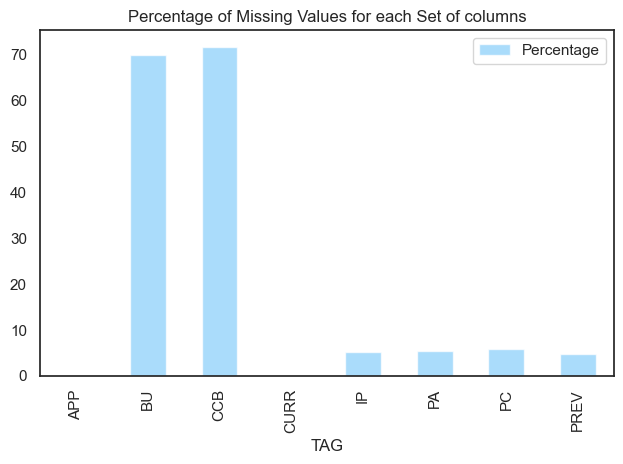

In [78]:
# count the number of NaN values in each column
num_nan = table.isna().mean()*100

nan_table = pd.DataFrame(num_nan.sort_values(ascending = False))

nan_table = nan_table.reset_index().rename(columns={"index": "Name",0:"Percentage"})

# extract TAG
nan_table['TAG'] = nan_table['Name'].str.split('_').str[-1]

nan_table = pd.DataFrame(nan_table.groupby("TAG")["Percentage"].last()).drop(index = "TARGET")

# create a bar chart of the percentage of missing values for the subset of data
nan_table.plot(kind='bar', color='lightskyblue', alpha=0.7)
plt.title("Percentage of Missing Values for each Set of columns")
plt.tight_layout()

Distribution of target variable

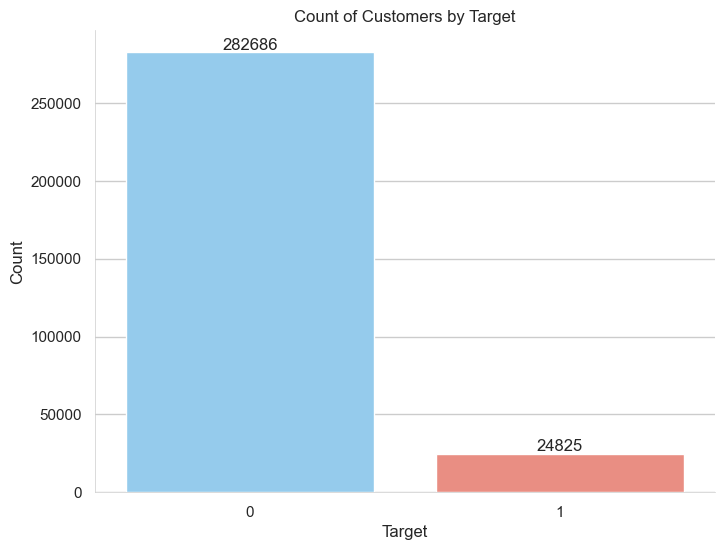

In [79]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Count of Customers by Target")
ax = sns.countplot(x="TARGET", data=table, palette=["lightskyblue", "salmon"])
ax.set_ylabel("Count")
ax.set_xlabel("Target")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

plt.show()


In [80]:
pd.DataFrame(table["TARGET"].value_counts(normalize = True)*100).rename(columns={"TARGET":"Percentage of Values"})

,Percentage of Values
0,91.927118
1,8.072882


**Findings:**
We can see that most of the clients are accepted and only 8% of the clients get his loan rejected.

We can also observe that our data is unbalanced which will impact our construction of the model. When trying different models we need to be aware of the balance of the data because it can lead to biased predictions. For example, if the majority of the training data belongs to one class (say class 0), a naive model that always predicts class 0 would achieve high accuracy without actually learning the underlying patterns. Thus, a model trained on unbalanced data may be more likely to predict the majority class, leading to poor performance on the minority class. This can be problematic if the minority class is the one we are most interested in predicting, for example in cases of fraud detection or disease diagnosis.
To address this issue, techniques such as oversampling the minority class, undersampling the majority class, or using class weights can be used to balance the training data and improve the model's performance on the minority class.

**See the main difference between being accepted or not**

In [81]:
table.groupby("TARGET").agg({'AMT_BALANCE_CCB': 'mean', 'NAME_CONTRACT_STATUS_Refused_PA': 'mean', 'AMT_CREDIT_APP':'mean', 'DAYS_EMPLOYED_APP':'mean'})

,AMT_BALANCE_CCB,NAME_CONTRACT_STATUS_Refused_PA,AMT_CREDIT_APP,DAYS_EMPLOYED_APP
TARGET,,,,
0,68583.247497,0.808167,602648.282002,2291.720782
1,102451.095747,1.234557,557778.527674,1794.814582


**Findings:** 
In order to gain deeper insights into the relationship between the features and the target variable, we conducted an analysis on variables that we thought would be more intuitively related to a client's loan request being rejected or not. Moreover, to take into account the fact that we have an unbalanced dataset, we used the “mean” as the aggregation method for all of the features.

 

For that reason, we selected the following features:

 

- AMT_BALANCE_CCB: Balance of previous credit card during previous credit
- NAME_CONTRACT_STATUS_Refused_PA: Number of times that a client’s loan request has been rejected in the past 
- AMT_CREDIT_APP: The credit amount of the loan requested
- DAYS_EMPLOYED_APP: How many days before the application the person started current employment

 

The first finding we can report is that the results for AMT_BALANCE_CCB and AMT_CREDIT_APP were counterintuitive. Higher credit card balances were registered in cases where loan requests were refused, and higher credit amounts asked for in the request were associated with cases where loan requests were accepted. The fact is that the opposite situation would be expected since in the cases of a higher credit card balance, there would be a higher probability of a client paying the loan, and therefore being accepted, for example.

 

Regarding the NAME_CONTRACT_STATUS_Refused_PA, in the cases when the loan request was declined (target = 1), we have more cases when the previous loan requests were also declined. This is indeed consistent with the expectation that past rejection is more likely to lead to a current rejection. 

 

Finally, regarding DAYS_EMPLOYED_APP, we can see that longer periods of current employment led to higher likelihoods of having a loan request being accepted, which is also consistent with expectations.

### Transformation Pipeline


In [82]:
#Adding columns for each column if the value is NaN given that, since the imputer was done previously to each table, a NaN value indicates that there is no information about these ID in the other tables (should not be considered as a normal NaN value)
def preprocess_df(df):
    new_df = df.copy()
    if df.isnull().any().any():
        for col in df.columns:
            if df[col].isnull().values.any():
                new_df[col + '_AVAILABLE'] = np.where(df[col].isnull(), 0, 1)
                new_df[col] = new_df[col].fillna(0)
        return new_df
    return new_df


table = preprocess_df(table)

In [83]:
#Split features into Categorical Binary and Numerical
variables_type = pd.DataFrame(table.dtypes)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in table:
    if ((list(table[i].unique()) == [0,1]) or (list(table[i].unique()) == [1,0]) or (list(table[i].unique()) == [1.0,0.0]) or (list(table[i].unique()) == [0.0,1.0])) and i != "TARGET":
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","TARGET"]]

float_with_no_binary = [i for i in float_variables if i not in cat_binary_variables and i not in ["SK_ID_CURR","TARGET"]]

num_variables = int_with_no_binary + float_with_no_binary

print(cat_binary_variables)
print(num_variables)

['NAME_INCOME_TYPE_Working_APP', 'NAME_EDUCATION_TYPE_Higher education_APP', 'CODE_GENDER_F_APP', 'CODE_GENDER_M_APP', 'REG_CITY_NOT_WORK_CITY_APP', 'REGION_RATING_CLIENT_W_CITY_3_APP', 'NAME_EDUCATION_TYPE_Secondary / secondary special_APP', 'REGION_RATING_CLIENT_3_APP', 'NAME_INCOME_TYPE_Pensioner_APP', 'FLAG_EMP_PHONE_APP', 'REG_CITY_NOT_LIVE_CITY_APP', 'FLAG_DOCUMENT_3_APP', 'REGION_RATING_CLIENT_W_CITY_1_APP', 'REGION_RATING_CLIENT_1_APP', 'LIVE_CITY_NOT_WORK_CITY_APP', 'NAME_CONTRACT_TYPE_Revolving loans_APP', 'NAME_CONTRACT_TYPE_Cash loans_APP', 'OCCUPATION_TYPE_Drivers_APP', 'NAME_HOUSING_TYPE_With parents_APP', 'ORGANIZATION_TYPE_Self-employed_APP', 'FLAG_DOCUMENT_6_APP', 'NAME_HOUSING_TYPE_House / apartment_APP', 'FLAG_WORK_PHONE_APP', 'OCCUPATION_TYPE_Low-skill Laborers_APP', 'NAME_FAMILY_STATUS_Single / not married_APP', 'NAME_FAMILY_STATUS_Married_APP', 'FLAG_PHONE_APP', 'NAME_INCOME_TYPE_State servant_APP', 'NAME_FAMILY_STATUS_Civil marriage_APP', 'FLAG_OWN_CAR_APP', 'OCC

In [84]:
#Split data set into 20% test and 80% training
X = table.drop(["SK_ID_CURR", "TARGET"], axis=1)

y = table["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
#Create the pipeline (only running the standard scaler, everything else is already preprocessed), fit and transform
num_pipeline = Pipeline([("std_scaler", StandardScaler())])
num_preprocessor = ColumnTransformer([('num_pipeline', num_pipeline, num_variables)])

X_train_num_preprocessed = num_preprocessor.fit_transform(X_train)
X_test_num_preprocessed = num_preprocessor.transform(X_test)

X_train_numdf = pd.DataFrame(X_train_num_preprocessed, columns=num_variables)
X_train_finaldf = pd.concat([X_train_numdf, X_train[cat_binary_variables].reset_index()], axis=1)

X_test_numdf = pd.DataFrame(X_test_num_preprocessed, columns=num_variables)
X_test_finaldf = pd.concat([X_test_numdf, X_test[cat_binary_variables].reset_index()], axis=1)


### Modeling

We not only want to run the models for the whole dataset but also see how we can improve if we do it on the 100 features with highest correlation with the Target and 50 features also with highest correlation but with squared terms

In [86]:
#Creating the 3 datasets
X_train_top100 = X_train_finaldf[list(pd.DataFrame(abs(X_train.corrwith(y_train)).sort_values(ascending=False))[:100].index)]

X_test_top100 = X_test_finaldf[list(pd.DataFrame(abs(X_train.corrwith(y_train)).sort_values(ascending=False))[:100].index)]

top50_corr_features = list(pd.DataFrame(abs(X_train.corrwith(y_train)).sort_values(ascending=False))[:50].index)

# square all the features
X_train_top50Squared = X_train_finaldf[top50_corr_features].apply(lambda x: np.square(x))

# concatenate the original and squared features datasets
X_train_top50Squared = pd.concat([X_train_finaldf[top50_corr_features], X_train_top50Squared], axis=1)

# square all the features
X_test_top50Squared = X_test_finaldf[top50_corr_features].apply(lambda x: np.square(x))

# concatenate the original and squared features datasets
X_test_top50Squared = pd.concat([X_test_finaldf[top50_corr_features], X_test_top50Squared], axis=1)

#Create a list of datasets with training and testing to loop through when building the models
training_sets = [X_train_finaldf, X_train_top100,X_train_top50Squared]
testing_sets = [X_test_finaldf, X_test_top100, X_test_top50Squared]


#### Random Forest Classifier

Model for : All
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 15}
Precision: 0.17192794720884608
Accuracy: 0.7400777197860267
Recall: 0.5843604768640129


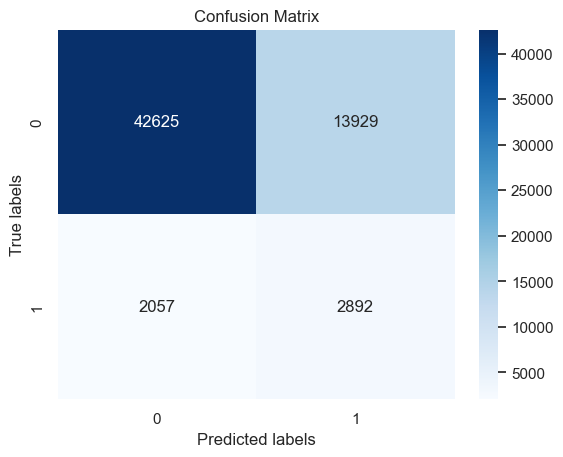

Model for : Top 100 Correlation
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
Precision: 0.17061982546430968
Accuracy: 0.7280620457538657
Recall: 0.6162861184077592


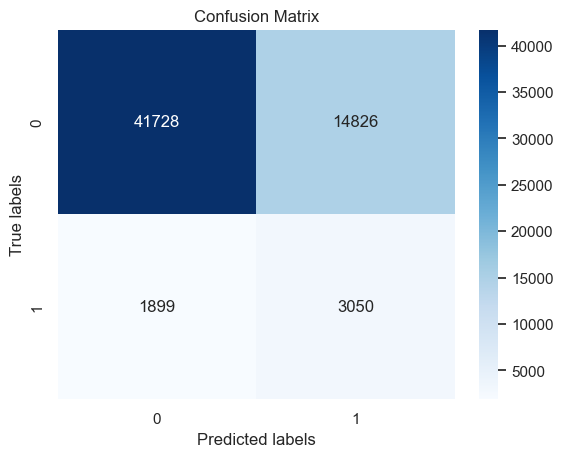

Model for : Top 50 Correlation with Squared Terms
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
Precision: 0.17358402700972117
Accuracy: 0.7371835520218526
Recall: 0.6025459688826026


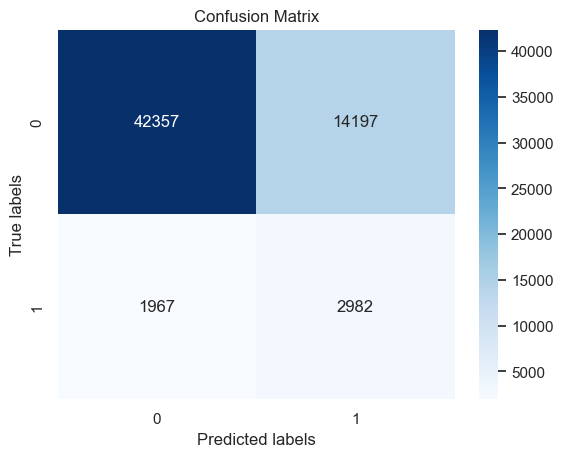

In [87]:
for i in range(len(training_sets)):
    print("Model for :",["All", "Top 100 Correlation", "Top 50 Correlation with Squared Terms"][i])
    #Perform a RandomForestClassifier using grid_search to help us finding the best hyperparameters for the n_estimators and max_depth using the recall as the decicion score

    # create a random forest classifier
    rfc = RandomForestClassifier(class_weight = 'balanced')

    # define the hyperparameter grid
    param_grid = {
        'n_estimators': [10, 15, 20],
        'max_depth': [10, 15, 20],
        'criterion' :["gini", "entropy", "log_loss"]
    }

    # perform grid search cross-validation
    grid_search_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='recall')
    grid_search_rfc.fit(training_sets[i], y_train)

    # print the best hyperparameters and corresponding accuracy score
    print('Best hyperparameters:', grid_search_rfc.best_params_)
    y_pred_rfc = grid_search_rfc.predict(testing_sets[i])
    print('Precision:', precision_score(y_test, y_pred_rfc))
    print('Accuracy:', accuracy_score(y_test, y_pred_rfc))
    print('Recall:', recall_score(y_test, y_pred_rfc))

    confusion = confusion_matrix(y_test, y_pred_rfc)

    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

    plt.title("Confusion Matrix")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

**Findings:** Based on the results we achieved, several conclusions can be taken.

Firstly, the Random Forest Classifier achieved a low precision in all three situations, regardless of what features were being used. This indicates that the models have a high false positive rate, which means they are identifying clients as having payment difficulties when they actually do not, therefore refusing their loan requests and leading to loss of potential revenue for Home Credit. With this low precision, the fact is that the business of Home Loans will be lower.

However, the recall values for all three models are high, which was our main goal given the high cost associated with false negatives, since the bank would have a high financial loss if a loan was provided for someone who won’t be able to pay it back. Therefore, our models are identifying correctly a significant number of clients with payment difficulties. 

It is also worth noting that the models perform slightly better using a smaller subset of features, achieving a higher recall (which was our goal) when using only the top 100 features with higher correlation with target or top 50 squared features with higher correlation with target. This fact suggests that some features of our dataset may not be relevant when predicting if a client will have payment difficulties or not. 
 
Besides all of this, we should also further investigate the values of the confusion matrix for each model. Having a highly unbalanced dataset, the fact is that the models are likely biased towards predicting the majority class (i.e., loans that are accepted). For that reason, we defined the class_weight parameter as “balanced”.  However, the fact is that the data was trained on the same number of 0 and 1 - therefore the result is that there are more 0 and, in fact, there are more 0, it makes sense in the confusion matrix. This can still be seen in the confusion matrices, with a much larger number of observations in the majority class and a lower number of observations in the minority class, which must be taking into account when analysing those values.

Therefore, the following conclusions can be achieved:

* FN are relatively significant in all three models, when compared to TP, which indicates that the models are not accurately predicting loans that will be rejected, which will lead to financial loss to Home Loans.
* The model with the top 100 features has the highest rate TP, therefore correctly identifying the higher number of loans that will be rejected. 
* The model with the top 50 features is better in terms of the trade-off between minimizing false negatives and maintaining a high true positive rate.


Therefore, the best model would be the one using the top 50 features more correlated to the target.

#### ADA Boost Classifier

Model for : All
Best hyperparameters: {'learning_rate': 0.5, 'n_estimators': 300}
Precision: 0.16928341384863124
Accuracy: 0.7058192283303254
Recall: 0.679733279450394


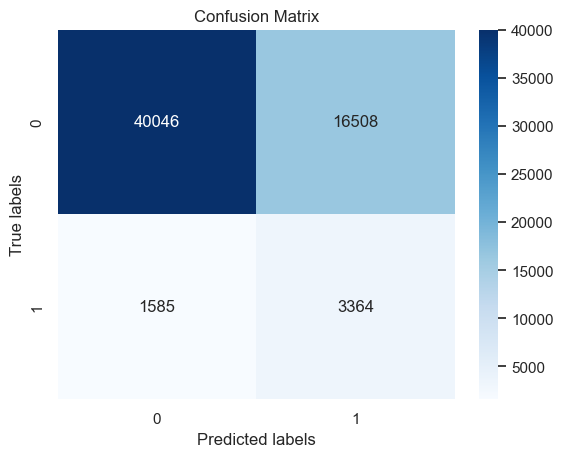

Model for : Top 100 Correlation
Best hyperparameters: {'learning_rate': 0.5, 'n_estimators': 300}
Precision: 0.1681540158427755
Accuracy: 0.7042908476009301
Recall: 0.6777126692261063


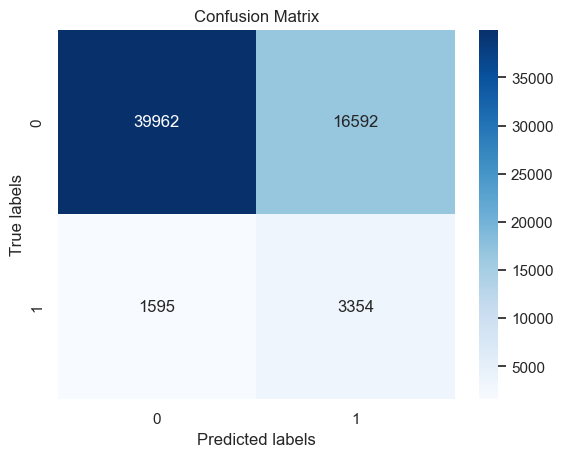

Model for : Top 50 Correlation with Squared Terms
Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 300}
Precision: 0.16240234375
Accuracy: 0.6946978196185551
Recall: 0.6720549605981007


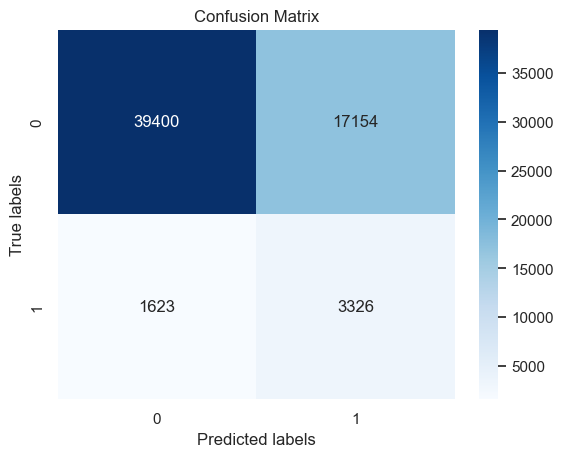

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

for i in range(len(training_sets)):
    print("Model for :",["All", "Top 100 Correlation", "Top 50 Correlation with Squared Terms"][i])
    
    # Create an ADA Boost Classifier
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(class_weight ="balanced",max_depth=1), algorithm="SAMME.R", random_state=42)

    # define the grid search parameters
    param_grid = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.1, 0.5, 1.0]
    }


    with parallel_backend('multiprocessing', n_jobs=-1):
    # perform grid search cross-validation
        grid_boost = GridSearchCV(ada_clf, param_grid=param_grid, cv=5, scoring='recall')
        grid_boost.fit(training_sets[i], y_train)

    # print the best hyperparameters and corresponding accuracy score
    print('Best hyperparameters:', grid_boost.best_params_)
    y_pred_boost = grid_boost.predict(testing_sets[i])

    print('Precision:', precision_score(y_test, y_pred_boost))
    print('Accuracy:', accuracy_score(y_test, y_pred_boost))
    print('Recall:', recall_score(y_test, y_pred_boost))

    confusion = confusion_matrix(y_test, y_pred_boost)

    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

    plt.title("Confusion Matrix")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


**Findings:** Based on the comparison of three models trained using AdaBoostClassifier with a DecisionTreeClassifier as the base estimator, we can conclude that the models trained on all variables and the top 100 correlation variables perform similarly in terms of precision, accuracy, and recall. They both outperform the model trained on the top 50 correlation variables with squared terms. The best hyperparameters for all three models are a learning rate of 0.5 and 300 estimators. The models trained on all variables and the top 100 correlation variables have slightly higher recall (around 0.68) compared to the model trained on the top 50 correlation variables with squared terms (0.672).

Model Evaluation - All Variables: The model trained on all variables achieved an accuracy of 0.706, indicating it correctly predicted the loan outcome for approximately 70.6% of the test cases. The precision score of 0.169 suggests that only 16.9% of the predicted loan rejections were accurate. However, the recall score of 0.680 indicates that the model was able to identify 68% of the actual loan rejections due to payment difficulties.

Model Evaluation - Top 100 Correlation Variables: The model trained on the top 100 correlation variables achieved an accuracy of 0.704, similar to the model trained on all variables. The precision score of 0.168 suggests that the model's predictions of loan rejections were accurate around 16.8% of the time. The recall score of 0.678 indicates that it successfully identified 67.8% of the actual loan rejections due to payment difficulties.

Model Evaluation - Top 50 Correlation Variables with Squared Terms: The model trained on the top 50 correlation variables with squared terms achieved an accuracy of 0.695, slightly lower than the other models. The precision score of 0.162 indicates that only 16.2% of the predicted loan rejections were accurate. The recall score of 0.672 suggests that it identified 67.2% of the actual loan rejections.

Overall, all three models exhibit relatively low precision, indicating a higher tendency to generate false positives. However, they demonstrate moderate to high recall values, suggesting a reasonable ability to identify actual loan rejections due to payment difficulties. Based on these evaluations, the models trained on all variables or the top 100 correlation variables would be preferable for prioritizing the identification of true positives.

#### Logistic Regression

Model for : All
Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
Precision: 0.1340782122905028
Accuracy: 0.9174024031348065
Recall: 0.0048494645382905635


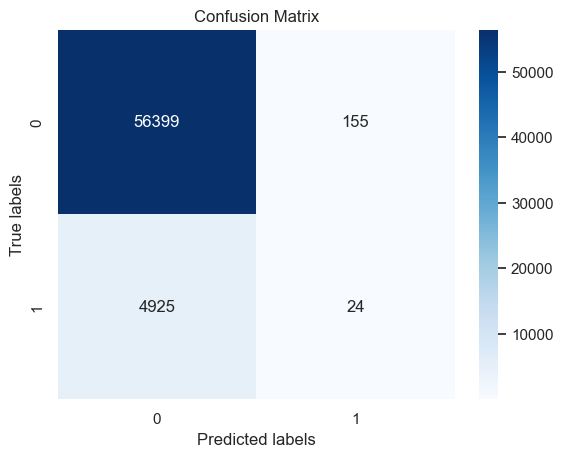

Model for : Top 100 Correlation
Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
Precision: 0.1630189042281976
Accuracy: 0.6917223550070728
Recall: 0.6847848050111134


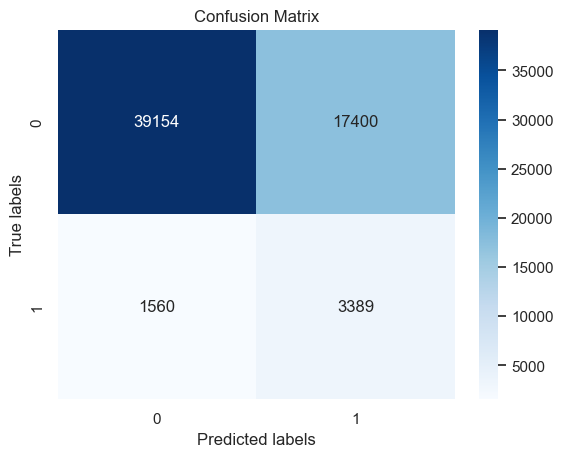

Model for : Top 50 Correlation with Squared Terms
Best hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}
Precision: 0.1587577160493827
Accuracy: 0.6894297839129798
Recall: 0.6651848858355224


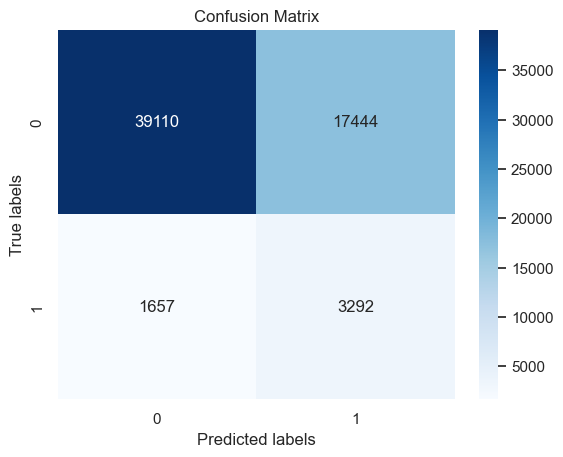

In [89]:
for i in range(len(training_sets)):
    print("Model for :",["All", "Top 100 Correlation", "Top 50 Correlation with Squared Terms"][i])

    # create a Logistic Regression
    logistic = LogisticRegression(class_weight = 'balanced', max_iter=2000)

    # define the hyperparameter grid
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1],
        'solver':['sag','saga','newton-cholesky'],
    }

    with parallel_backend('multiprocessing', n_jobs=-1):
    # perform grid search cross-validation
        grid_search_logreg = GridSearchCV(logistic, param_grid=param_grid, cv=5, scoring='recall')
        grid_search_logreg.fit(training_sets[i], y_train)

    # print the best hyperparameters and corresponding accuracy score
    print('Best hyperparameters:', grid_search_logreg.best_params_)
    y_pred_logreg = grid_search_logreg.predict(testing_sets[i])
    print('Precision:', precision_score(y_test, y_pred_logreg))
    print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
    print('Recall:', recall_score(y_test, y_pred_logreg))

    confusion = confusion_matrix(y_test, y_pred_logreg)

    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

    plt.title("Confusion Matrix")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

**Findings:** When evaluating the Logistic Regression model we can observe that in the first model, which uses all the available features, has a very high accuracy, but a very low recall, meaning that it correctly predicts most of the non-default clients, but fails to identify the majority of those who will default. This could be due to the fact that some of the features are not relevant for the classification task, or that the imbalanced nature of the dataset affects the model's ability to predict the minority class.

The other two models, which use only the top 100 and top 50 features with highest correlation to the target variable respectively, have lower accuracy, but significantly higher recall values. This means that they are better at identifying clients who are likely to default, but they may also classify some non-default clients as default. These models have a higher chance of being useful in practice, since it's more important for the company to avoid false negatives (clients who are likely to default but are classified as non-default) than false positives (clients who are classified as default but are likely to pay back their loan).

Overall, considering the goal of maximizing recall, the second model, which uses the top 100 correlated features, seems to be the best choice, as it has a higher recall than the third model, while maintaining a similar precision and accuracy.




### Conclusion

After conducting an extensive analysis of three different models, Random Forest Classifier, Ada Boost Classifier, and Logistic Regression, trained on three different datasets, we have concluded that the best model for our business problem is the Ada Boost Classifier. We balanced each dataset by setting the class_weight parameter to balance in each model.

For the Random Forest Classifier, we achieved the best results using the top 50 features more correlated with squared terms with the hyperparameters {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}. For the Ada Boost Classifier, the best results were obtained when using all features with the hyperparameters {'learning_rate': 0.5, 'n_estimators': 300}. Finally, for the Logistic Regression, we used the max_iter=2000 parameter for all datasets, and the best model was obtained using the top 100 features more correlated with the hyperparameters {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}.

By conducting an in-depth analysis of three different models, we gained further insights on our business problem. Namely on the Random Forest Classifier, Ada Boost Classifier, and Logistic Regression, trained on three different datasets. After thorough evaluation, we have identified the ultimate solution to our problem - the Ada Boost Classifier.

Despite not having the highest recall among all three models, the Ada Boost Classifier achieved better results in terms of precision and accuracy. The difference between the Ada Boost and the Logistic Regression was less than a mere 0.6%. By selecting the Ada Boost Classifier, we can now effectively reduce costs associated with home loans by avoiding accepting applications that should be rejected, which was our main goal.